In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import models, transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision import transforms

from torch.utils.data import DataLoader, SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch.cuda.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bases_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Dataset/"
models_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/"

train_dataset_path = bases_path + "personal_Cleansed"
test_dataset_path = bases_path + "test/"
model_save_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/best_model.pth"  # Chemin de sauvegarde du modèle
full_model_save_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/full_best_model.pth"  # Chemin de sauvegarde du modèle

In [ ]:
batch_size = 16  # @param [1,2,4,8,16,24,26, 32,64,128, 256] {type:"raw"}

input_dim = 224  # @param [32, 224,256,299,380] {type:"raw"}
image_size = (input_dim, input_dim)

epochs = 10  # @param [1, 5, 10,20,30,50,75, 100,200] {type:"raw"}

train_split = 0.9  # @param [0.9] {type:"raw"}

validation_split = 0.1  # @param [1e-1,2e-1,3e-1,4e-1] {type:"raw"}

# -------------------------
# Early Stopping call Back
# -------------------------
early_patience = 5 # @param [1,2,3,5,10,15,20,50,100] {type:"raw"}

optimizer_cost_function_train = "Adam"  # @param ["Adam", "SGD"]
train_learning_rate = 0.001 # @param [0.1,0.01,0.03, 0.003,0.0003,0.001,0.005,0.0001,0.00001] {type:"raw"}

optimizer_cost_function_refine = "SGD"  # @param ["Adam", "SGD"]
refine_learning_rate = 0.01 # @param [0.1,0.01,0.03,0.001,0.005,0.0001,0.00001] {type:"raw"}

dropout_rate = 0.5 # @param [0.0,0.1,0.2,0.3,0.4,0.5] {type:"raw"}

l2_rate = 0.00003 # @param [0,0.03,0.003,0.0003,0.00003] {type:"raw"}

nb_nodes = 1024 # @param [512,1024,2048] {type:"raw"}

head_layer = 5 # @param [1,2,3,4,5,6,7,8,12,20] {type:"raw"}

last_level = 256 # @param [128,256,512] {type:"raw"}

In [ ]:
class ModelCheckpointCallback:
    def __init__(self, epoch_to_save, model_save_path):
        self.epoch_to_save = epoch_to_save
        self.model_save_path = model_save_path
        self.full_model_save_path = full_model_save_path
        self.best_accuracy = 0.0

    def __call__(self, epoch, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            torch.save(model.state_dict(), self.model_save_path)
            torch.save(model, self.full_model_save_path)
            print(f'Model saved at epoch {epoch} with accuracy {accuracy:.3f}')

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

In [ ]:
# Charger MobileNetV3-Small pré-entraîné
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 113MB/s]


In [ ]:
# Déterminer la taille de sortie de la dernière couche convolutive
def get_model_output_size(model, input_dim):
    with torch.no_grad():
        sample_input = torch.randn(1, 3, input_dim, input_dim)
        features = model.features(sample_input)
        output = model.avgpool(features)
        output = torch.flatten(output, 1)
        return output.shape[1]

In [ ]:
num_features = get_model_output_size(model, input_dim)

In [ ]:
# Adapter le classificateur pour inclure une couche cachée avec 256 neurones
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(256, 3)
)

In [ ]:
# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Afficher le modèle
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Transformations pour les données d'entraînement et de validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Charger les données
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

In [ ]:
# Créer des indices pour le split train/validation
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)

In [ ]:
# Création des samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Création des DataLoaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
# Geler les premières couches du modèle
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
# Dégeler les couches à partir de la couche souhaitée
if isinstance(model, models.MobileNetV3):
    for name, child in model.features.named_children():
        if int(name) >= 9:  # Dégeler à partir de la couche 11
            for param in child.parameters():
                param.requires_grad = True

In [ ]:
# Définir l'optimiseur et la fonction de perte
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Initialiser le modèle pour l'entraînement
fire_model = model

In [ ]:
# Initialiser le callback
checkpoint_callback = ModelCheckpointCallback(early_patience, model_save_path)

In [ ]:
# Utiliser le scaler pour la précision mixte
scaler = amp.GradScaler()

In [ ]:
# Boucle d'entraînement et de validation
for epoch in range(epochs):
    fire_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(trainloader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        batch_correct, batch_total = calculate_accuracy(outputs, labels)
        correct += batch_correct
        total += batch_total

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    print(f'Epoch {epoch + 1} Train Loss: {train_loss:.3f} Accuracy: {train_accuracy:.3f}')

    fire_model.eval()  # Mode évaluation
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Validation Epoch {epoch+1}"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = fire_model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

            batch_correct, batch_total = calculate_accuracy(outputs, labels)
            correct += batch_correct
            total += batch_total

    val_loss = running_loss / len(valloader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.3f} Accuracy: {val_accuracy:.3f}')

    # Appeler le callback après chaque époque
    checkpoint_callback(epoch + 1, fire_model, val_accuracy)

Training Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1: 100%|██████████| 97/97 [02:07<00:00,  1.32s/it]


Epoch 1 Train Loss: 0.863 Accuracy: 0.657


Validation Epoch 1: 100%|██████████| 11/11 [00:14<00:00,  1.32s/it]


Epoch 1 Validation Loss: 0.456 Accuracy: 0.884
Model saved at epoch 1 with accuracy 0.884


Training Epoch 2: 100%|██████████| 97/97 [00:08<00:00, 12.02it/s]


Epoch 2 Train Loss: 0.316 Accuracy: 0.909


Validation Epoch 2: 100%|██████████| 11/11 [00:01<00:00,  5.54it/s]


Epoch 2 Validation Loss: 0.165 Accuracy: 0.948
Model saved at epoch 2 with accuracy 0.948


Training Epoch 3: 100%|██████████| 97/97 [00:08<00:00, 12.01it/s]


Epoch 3 Train Loss: 0.194 Accuracy: 0.939


Validation Epoch 3: 100%|██████████| 11/11 [00:02<00:00,  5.36it/s]


Epoch 3 Validation Loss: 0.113 Accuracy: 0.953
Model saved at epoch 3 with accuracy 0.953


Training Epoch 4: 100%|██████████| 97/97 [00:08<00:00, 11.24it/s]


Epoch 4 Train Loss: 0.165 Accuracy: 0.946


Validation Epoch 4: 100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


Epoch 4 Validation Loss: 0.102 Accuracy: 0.959
Model saved at epoch 4 with accuracy 0.959


Training Epoch 5: 100%|██████████| 97/97 [00:08<00:00, 11.52it/s]


Epoch 5 Train Loss: 0.145 Accuracy: 0.947


Validation Epoch 5: 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]


Epoch 5 Validation Loss: 0.108 Accuracy: 0.971
Model saved at epoch 5 with accuracy 0.971


Training Epoch 6: 100%|██████████| 97/97 [00:09<00:00,  9.81it/s]


Epoch 6 Train Loss: 0.101 Accuracy: 0.964


Validation Epoch 6: 100%|██████████| 11/11 [00:01<00:00,  7.94it/s]


Epoch 6 Validation Loss: 0.090 Accuracy: 0.971


Training Epoch 7: 100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


Epoch 7 Train Loss: 0.106 Accuracy: 0.968


Validation Epoch 7: 100%|██████████| 11/11 [00:01<00:00,  6.36it/s]


Epoch 7 Validation Loss: 0.086 Accuracy: 0.971


Training Epoch 8: 100%|██████████| 97/97 [00:08<00:00, 11.24it/s]


Epoch 8 Train Loss: 0.097 Accuracy: 0.966


Validation Epoch 8: 100%|██████████| 11/11 [00:01<00:00,  7.22it/s]


Epoch 8 Validation Loss: 0.073 Accuracy: 0.977
Model saved at epoch 8 with accuracy 0.977


Training Epoch 9: 100%|██████████| 97/97 [00:07<00:00, 12.17it/s]


Epoch 9 Train Loss: 0.094 Accuracy: 0.973


Validation Epoch 9: 100%|██████████| 11/11 [00:01<00:00,  6.80it/s]


Epoch 9 Validation Loss: 0.081 Accuracy: 0.965


Training Epoch 10: 100%|██████████| 97/97 [00:08<00:00, 11.06it/s]


Epoch 10 Train Loss: 0.074 Accuracy: 0.975


Validation Epoch 10: 100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

Epoch 10 Validation Loss: 0.077 Accuracy: 0.977


In [ ]:
# Mettre le modèle en mode évaluation
fire_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Désactiver le calcul des gradients pour économiser de la mémoire et accélérer le traitement
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(testloader, desc="Testing"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            probs = nn.functional.softmax(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss /= len(testloader)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.3f}')
    print(f'Test Accuracy: {accuracy:.3f}')

Testing: 100%|██████████| 19/19 [00:36<00:00,  1.90s/it]

Test Loss: 0.211
Test Accuracy: 0.923


In [ ]:
# Renommer (déplacer) le fichier de modèle avec la précision de test
final_model_save_path = f"{models_path}model_MobileNet_V3_Small_Weights_test_acc_{accuracy:.3f}.pth"
shutil.move(checkpoint_callback.model_save_path, final_model_save_path)
print(f'Model saved as {final_model_save_path}')

Model saved as /content/drive/MyDrive/HackIA_2024_GRP_2/Models/model_MobileNet_V3_Small_Weights_test_acc_0.923.pth


In [ ]:
# Renommer (déplacer) le fichier de modèle avec la précision de test
full_final_model_save_path = f"{models_path}full_model_MobileNet_V3_Small_Weights_test_acc_{accuracy:.3f}.pth"
shutil.move(checkpoint_callback.full_model_save_path, full_final_model_save_path)
print(f'Model saved as {full_final_model_save_path}')


Model saved as /content/drive/MyDrive/HackIA_2024_GRP_2/Models/full_model_MobileNet_V3_Small_Weights_test_acc_0.923.pth


ROC-AUC: 0.991
F1 Score: 0.923
Confusion Matrix:
[[98  0  2]
 [ 4 82 14]
 [ 1  2 97]]


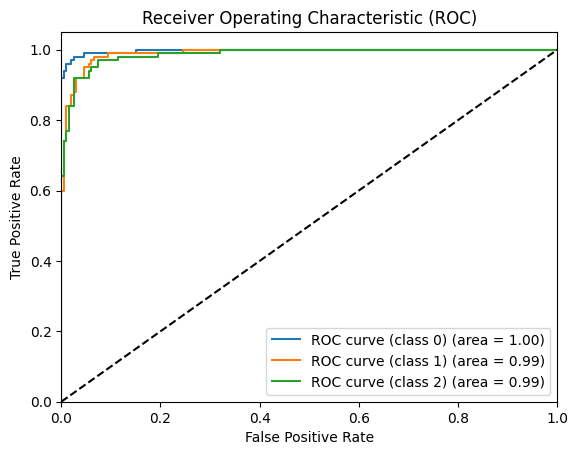

In [ ]:
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# Calculer les métriques supplémentaires
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'ROC-AUC: {roc_auc:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Tracer la courbe ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Afficher 5 images aléatoires par classe
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
classes = train_dataset.classes  # Utilisez les mêmes classes que pour l'entraînement
for cls in classes:
    cls_idx = train_dataset.class_to_idx[cls]
    cls_indices = [i for i, label in enumerate(train_dataset.targets) if label == cls_idx]
    random_indices = np.random.choice(cls_indices, 5, replace=False)
    print(f"Classe: {cls}")
    for idx in random_indices:
        img, _ = train_dataset[idx]
        imshow(img, cls)

Output hidden; open in https://colab.research.google.com to view.